In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black
%load_ext dotenv
%dotenv
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

In [17]:
import os
import glob
import tempfile
import cv2
import subprocess

import numpy as np

from matplotlib import pyplot as plt
import plotnine as p9
import pandas as pd

from metaflow import Metaflow, Run, Flow, Step
import scipy.stats


from PIL import Image
from paddleocr import PaddleOCR

from paddleocr import PaddleOCR

%matplotlib inline

<IPython.core.display.Javascript object>

In [18]:
def run_ssocr(image, params, commands):
    # Define the command and parameters
    cmd = ["./ssocr-2.22.2/ssocr"]

    # Add the parameters to the command
    for key, value in params.items():
        if value is None:
            cmd.append(f"--{key}")
        else:
            cmd.append(f"--{key}={value}")

    for _cmd in commands:
        cmd.extend(_cmd.split())

    # If the input is a numpy array, write it to a temporary file
    if isinstance(image, str):
        cmd.append(image)
    else:
        # Create a temporary file
        temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        temp_file_path = temp_file.name
        # Write the image to the temporary file
        cv2.imwrite(temp_file_path, image)
        cmd.append(temp_file_path)

    # print(f"{cmd=}")

    # Run the command and get the output
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Delete the temporary file if it was used
    if not isinstance(image, str):
        os.remove(temp_file_path)

    # Check for errors
    if result.stderr:
        print(f"Error: {result.stderr.decode()}")

    # Return the output
    return result.stdout.decode().strip()

<IPython.core.display.Javascript object>

[2023/05/20 11:39:31] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/mike/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/mike/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

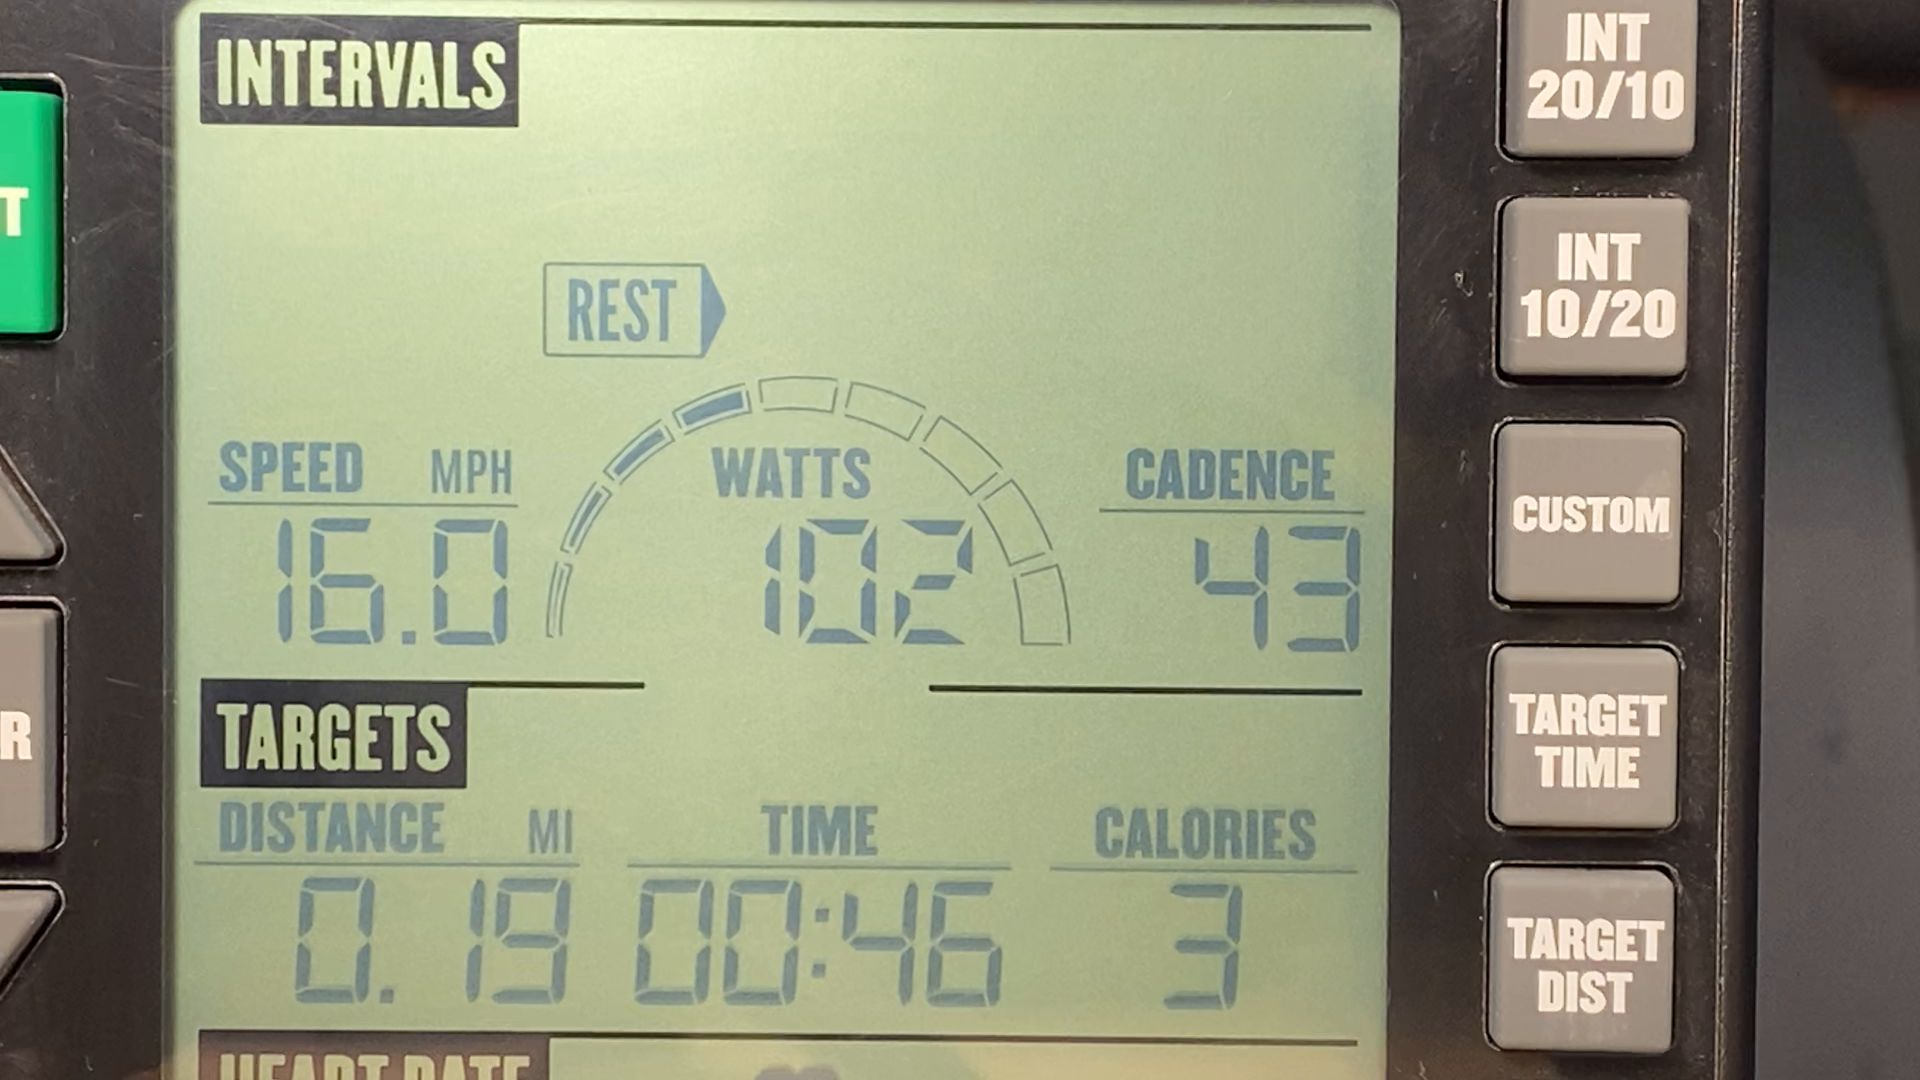

<IPython.core.display.Javascript object>

In [9]:
ocr = PaddleOCR(
    use_angle_cls=True, lang="en"
)  # need to run only once to download and load model into memory

im = Image.open("/bucket/exercise-machina/tmpqdhq4d5e/frames/output_1404.png")
im

In [10]:
def paddle_results_to_df(result):
    df = pd.DataFrame(result, columns=["bbox", "inference"])
    df[["inference_text", "inference_score"]] = pd.DataFrame(
        df["inference"].tolist(), index=df.index
    )

    df.drop(columns="inference")
    return df


def crop_image(image, bbox):
    """
    Crop an image (in numpy representation) to the given bounding box.

    Args:
    - image (numpy.ndarray): The input image in numpy format (height, width, channels)
    - bbox (list or tuple): The bounding box as (x_min, y_min, x_max, y_max)

    Returns:
    - cropped_image (numpy.ndarray): The cropped image
    """
    x_min, y_min, x_max, y_max = bbox
    cropped_image = image[y_min:y_max, x_min:x_max]

    return cropped_image


def make_polygons_2d(polygons):
    return np.concatenate(polygons).reshape(-1, 2).astype(np.float32)


def super_bounding_box(xy):
    xx, yy = xy[:, 0], xy[:, 1]

    return [xx.min(), xx.max(), yy.min(), yy.max()]


def best_match_2(text, markers):
    # calculate the best match out of the possible markers
    best = process.extractOne(text, markers, score_cutoff=90)
    if best is None:
        return ""
    return best[0]


def compute_distance(bbox1, bbox2):
    center1 = bbox1.mean(axis=0)
    try:
        # Compute centers of mass
        center1 = bbox1.mean(axis=0)
        center2 = bbox2.mean(axis=0)

        # Compute Euclidean distance between centers
        distance = np.linalg.norm(center1 - center2)
    except:
        return 1000

    return distance


def compute_angle(bbox1, bbox2):
    try:
        # Compute centers of mass
        center1 = bbox1.mean(axis=0)
        center2 = bbox2.mean(axis=0)

        # Compute angle relative to bbox1
        diff = center2 - center1
        angle = math.atan2(diff[1], diff[0]) * 180 / math.pi
    except:
        return 180

    return angle


def process_group_2(group):
    landmarks = group.assign(
        inference_clean=group["inference_text"].apply(best_match_2)
    )

    uniques = ["SPEED", "WATTS", "CADENCE", "CALORIES"]
    surround_box = super_bounding_box(
        make_polygons_2d(
            landmarks.query("inference_clean.isin(@uniques)").bbox.to_numpy()
        )
    )
    xl, xr, yt, yb = surround_box
    w = abs(xl - xr)
    h = abs(yt - yb)
    print(w, h)
    # surround_box = [xl, yt, round(xr + 1.05 * w), round(yb - h)]
    return (round(xl - 0.02 * w), yt, round(xr + 0.075 * w), round(yb + 0.42 * h))

<IPython.core.display.Javascript object>

In [12]:
def plausible_number(w, thresh=0.5):
    return (sum(1 for c in w if c.isdigit() or c in ":.") / len(w)) > thresh


def locate_numbers(
    df,
    landmarks=(
        "SPEED",
        "WATTS",
        "CADENCE",
        "CALORIES",
        "DISTANCE",
        "TIME",
    ),
    min_score=0.9,
):
    candidates_df = (
        df.query("inference_score >= @min_score")
        .loc[lambda f: f.inference_text.apply(plausible_number)]
        .reset_index(drop=True)
        .assign(box_id=lambda f: range(len(f)))
    )

    out = []
    for landmark in landmarks:
        rec = df.query("inference_text == @landmark")
        if landmark == "TIME":
            # TIME matches two places typically, we want the one more to the left.
            rec = (
                rec.assign(
                    bbox_left=lambda f: [e[:, 0].min() for e in f.bbox]
                ).sort_values("bbox_left")
            ).head(1)
        assert len(rec) == 1
        rec = rec.squeeze()

        _df = (
            candidates_df.assign(
                distance_from_ref=lambda f: [
                    compute_distance(rec.bbox, e) for e in f.bbox
                ],
                angle_from_ref=lambda f: [compute_angle(rec.bbox, e) for e in f.bbox],
            )
            .assign(
                belowness_score=lambda f: f.distance_from_ref
                + abs(f.angle_from_ref - 90)
            )
            .sort_values("belowness_score")
        )

        out.append(_df.head(1).assign(landmark=landmark, landmark_bbox=[rec.bbox]))

    return (
        pd.concat(out)
        .sort_values(["box_id", "belowness_score"])
        .assign(
            inference_text=lambda f: f.inference_text.where(
                ~f.duplicated(subset="box_id"), None
            ),
            inference_score=lambda f: f.inference_score.where(
                f.inference_text.notnull(), None
            ),
            bbox=lambda f: f.bbox.where(f.inference_text.notnull(), None),
        )
        .loc[
            :,
            [
                "landmark",
                "inference_text",
                "inference_score",
                # "distance_from_ref",
                # "angle_from_ref",
                # "belowness_score",
                # "box_id",
                "landmark_bbox",
                "bbox",
            ],
        ]
        .rename(columns={"bbox": "match_bbox"})
        .sort_values("landmark")
        .reset_index(drop=True)
    )


ff = paddle_results_to_df(ocr.ocr(np.asarray(im), cls=True)[0])
# ff


bb = locate_numbers(ff.assign(bbox=lambda f: f.bbox.apply(make_polygons_2d)))
bb


# imc = im.crop(bb)

# resize_width = 1000
# resize_height = int(
#     imc.height * (resize_width / imc.width)
# )
# imd = imc.resize(
#     (resize_width, resize_height), Image.LANCZOS
# )
# imd

# paddle_results_to_df(ocr.ocr(np.asarray(imd), cls=True)[0])

[2023/05/20 11:40:18] ppocr DEBUG: dt_boxes num : 28, elapse : 0.33571410179138184
[2023/05/20 11:40:18] ppocr DEBUG: cls num  : 28, elapse : 0.10822939872741699
[2023/05/20 11:40:20] ppocr DEBUG: rec_res num  : 28, elapse : 1.5384745597839355


,landmark,inference_text,inference_score,landmark_bbox,match_bbox
0,CADENCE,None,NaN,"[[1122.0, 443.0], [1340.0, 443.0], [1340.0, 50...",None
1,CALORIES,3,0.956618,"[[1093.0, 800.0], [1320.0, 804.0], [1319.0, 86...","[[1158.0, 891.0], [1240.0, 891.0], [1240.0, 10..."
2,DISTANCE,None,NaN,"[[213.0, 794.0], [450.0, 798.0], [449.0, 854.0...",None
3,SPEED,16.0,0.996945,"[[216.0, 437.0], [370.0, 437.0], [370.0, 494.0...","[[258.0, 503.0], [531.0, 509.0], [528.0, 654.0..."
4,TIME,00:46,0.957265,"[[758.0, 798.0], [882.0, 798.0], [882.0, 858.0...","[[616.0, 881.0], [1008.0, 881.0], [1008.0, 100..."
5,WATTS,102,0.997975,"[[708.0, 441.0], [878.0, 441.0], [878.0, 504.0...","[[752.0, 504.0], [996.0, 504.0], [996.0, 653.0..."


<IPython.core.display.Javascript object>

In [16]:
config = {
    "SPEED": dict(
        sel=(-0.2, 1.25, 1.03, 2.7),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "WATTS": dict(
        sel=(-0.2, 1.1, 0.6, 2.5),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "CADENCE": dict(
        sel=(0, 1.25, 0.20, 2.9),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "DISTANCE": dict(
        sel=(0, 1.3, 0.75, 3.25),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "TIME": dict(
        sel=(-1.2, 1.2, 1.45, 2.75),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "CALORIES": dict(
        sel=(0, 1.2, 0.2, 2.5),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
}


sample = (
    pd.Series(glob.glob("/bucket/exercise-machina/tmpqdhq4d5e/frames/*.png"))
    .sample(5, random_state=2009, replace=False)
    .sort_values()
    .tolist()
)
sample = sorted(glob.glob("/bucket/exercise-machina/tmpqdhq4d5e/frames/output_1*.png"))

match_frames = []
for e in sample:
    im = Image.open(e)
    ocr_df = paddle_results_to_df(ocr.ocr(np.asarray(im), cls=True)[0]).assign(
        bbox=lambda f: f.bbox.apply(make_polygons_2d)
    )
    order = int("".join([c for c in os.path.basename(e) if c.isdigit()]))
    match_frame = locate_numbers(ocr_df).assign(frame=e, frame_num=order)

    ssocr_inf = []
    for rec in match_frame.itertuples():
        cfg = config[rec.landmark]
        imc, out = ssocr_subimage(im, rec.landmark_bbox, cfg["sel"], cfg["ssocr_conf"])
        ssocr_inf.append(out)
    match_frame = match_frame.assign(ssocr=ssocr_inf)

    match_frames.append(match_frame)

matches = pd.concat(match_frames).sort_values(["frame_num", "landmark"])
matches.to_csv("ocr-output.csv")

[2023/05/20 11:41:45] ppocr DEBUG: dt_boxes num : 28, elapse : 0.270263671875
[2023/05/20 11:41:45] ppocr DEBUG: cls num  : 28, elapse : 0.1059122085571289
[2023/05/20 11:41:46] ppocr DEBUG: rec_res num  : 28, elapse : 1.5562336444854736


NameError: name 'run_ssocr' is not defined

<IPython.core.display.Javascript object>

<Axes: xlabel='landmark'>

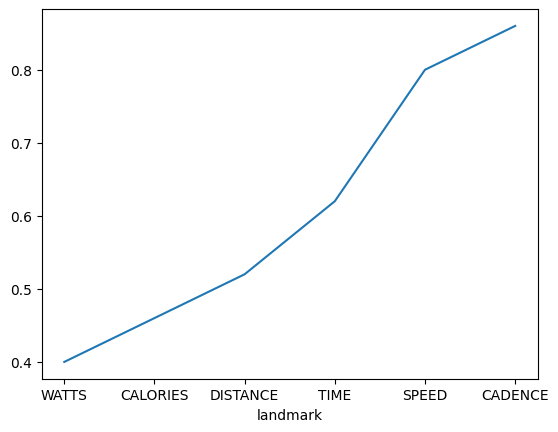

<IPython.core.display.Javascript object>

In [474]:
matches.assign(assigned=lambda f: f.inference_text.notnull()).groupby(
    "landmark"
).assigned.mean().sort_values().plot()

In [517]:
matches.head()

(matches.inference_text == matches.ssocr).mean()

,landmark,inference_text,inference_score,landmark_bbox,match_bbox,frame,ssocr
0,CADENCE,None,NaN,"[[1121.0, 440.0], [1338.0, 445.0], [1337.0, 50...",None,output_1008.png,41
1,CALORIES,None,NaN,"[[1093.0, 796.0], [1319.0, 803.0], [1317.0, 86...",None,output_1008.png,2
2,DISTANCE,0.14,0.972719,"[[216.0, 800.0], [448.0, 800.0], [448.0, 850.0...","[[294.0, 879.0], [592.0, 879.0], [592.0, 995.0...",output_1008.png,0.1_
3,SPEED,15.2,0.999608,"[[214.0, 435.0], [370.0, 435.0], [370.0, 492.0...","[[254.0, 497.0], [523.0, 503.0], [520.0, 658.0...",output_1008.png,15.2
4,TIME,EE:00,0.903045,"[[758.0, 796.0], [882.0, 796.0], [882.0, 858.0...","[[616.0, 879.0], [1008.0, 879.0], [1008.0, 999...",output_1008.png,00133


0.30666666666666664

<IPython.core.display.Javascript object>

In [37]:
sample = (
    pd.Series(glob.glob("/bucket/exercise-machina/tmpqdhq4d5e/frames/*.png"))
    .sample(20, random_state=2009, replace=False)
    .sort_values()
    .tolist()
)
images = [Image.open(e) for e in sample]
matches = [
    locate_numbers(
        paddle_results_to_df(ocr.ocr(np.asarray(im), cls=True)[0]).assign(
            bbox=lambda f: f.bbox.apply(make_polygons_2d)
        )
    ).assign(frame=e)
    for e, im in zip(sample, images)
]
matches = pd.concat(matches)

[2023/05/20 11:59:01] ppocr DEBUG: dt_boxes num : 30, elapse : 0.2693510055541992
[2023/05/20 11:59:02] ppocr DEBUG: cls num  : 30, elapse : 0.11184144020080566
[2023/05/20 11:59:03] ppocr DEBUG: rec_res num  : 30, elapse : 1.650587797164917
[2023/05/20 11:59:04] ppocr DEBUG: dt_boxes num : 27, elapse : 0.26795172691345215
[2023/05/20 11:59:04] ppocr DEBUG: cls num  : 27, elapse : 0.1012716293334961
[2023/05/20 11:59:05] ppocr DEBUG: rec_res num  : 27, elapse : 1.486616849899292
[2023/05/20 11:59:05] ppocr DEBUG: dt_boxes num : 26, elapse : 0.26839733123779297
[2023/05/20 11:59:06] ppocr DEBUG: cls num  : 26, elapse : 0.09768509864807129
[2023/05/20 11:59:07] ppocr DEBUG: rec_res num  : 26, elapse : 1.4308066368103027
[2023/05/20 11:59:07] ppocr DEBUG: dt_boxes num : 27, elapse : 0.26938772201538086
[2023/05/20 11:59:07] ppocr DEBUG: cls num  : 27, elapse : 0.10195207595825195
[2023/05/20 11:59:09] ppocr DEBUG: rec_res num  : 27, elapse : 1.5184316635131836
[2023/05/20 11:59:09] ppocr 

<IPython.core.display.Javascript object>

cf=[609, 870, 1062, 1028]
best_score=183.67903486113514 ix=2 d=-6 cfp=[609, 870, 1056, 1028]
best_score=183.6780933101801 ix=2 d=-5 cfp=[609, 870, 1057, 1028]
best_score=183.65664176253816 ix=2 d=-4 cfp=[609, 870, 1058, 1028]
best_score=183.63644021947994 ix=2 d=-3 cfp=[609, 870, 1059, 1028]
best_score=183.63631166609645 ix=2 d=3 cfp=[609, 870, 1065, 1028]
best_score=183.63560406629512 ix=2 d=4 cfp=[609, 870, 1066, 1028]
best_score=183.6180089687586 ix=2 d=5 cfp=[609, 870, 1067, 1028]
best_score=183.6177992998483 ix=2 d=7 cfp=[609, 870, 1069, 1028]
best_score=183.60900536969822 ix=2 d=8 cfp=[609, 870, 1070, 1028]
best_score=183.60287548147133 ix=2 d=9 cfp=[609, 870, 1071, 1028]
best_score=183.59394895202158 ix=2 d=11 cfp=[609, 870, 1073, 1028]


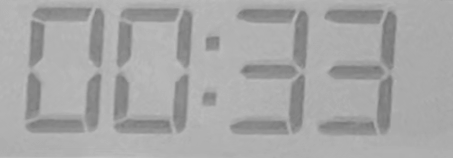

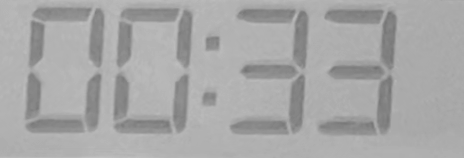

'00133'

cf=[598, 873, 1072, 1042]
best_score=186.11404531641261 ix=2 d=1 cfp=[598, 873, 1073, 1042]
best_score=186.09825034993145 ix=2 d=2 cfp=[598, 873, 1074, 1042]
best_score=186.07229627813376 ix=2 d=3 cfp=[598, 873, 1075, 1042]
best_score=186.06520546862114 ix=2 d=4 cfp=[598, 873, 1076, 1042]
best_score=186.05951433288857 ix=2 d=5 cfp=[598, 873, 1077, 1042]
best_score=186.0486338151341 ix=2 d=6 cfp=[598, 873, 1078, 1042]
best_score=186.04373996365396 ix=2 d=7 cfp=[598, 873, 1079, 1042]
best_score=186.0267399343554 ix=2 d=8 cfp=[598, 873, 1080, 1042]
best_score=186.01667667861258 ix=2 d=9 cfp=[598, 873, 1081, 1042]
best_score=186.01199901652538 ix=2 d=10 cfp=[598, 873, 1082, 1042]
best_score=186.00010248659524 ix=2 d=11 cfp=[598, 873, 1083, 1042]
best_score=185.98189086090923 ix=2 d=12 cfp=[598, 873, 1084, 1042]
best_score=185.9646376849199 ix=2 d=13 cfp=[598, 873, 1085, 1042]
best_score=185.9620606898612 ix=2 d=14 cfp=[598, 873, 1086, 1042]
best_score=185.95366689332468 ix=3 d=-15 cfp=[598

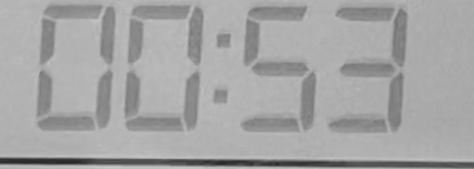

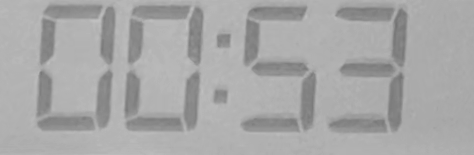

'00153'

cf=[609, 870, 1062, 1023]
best_score=185.02047791098838 ix=2 d=-15 cfp=[609, 870, 1047, 1023]
best_score=184.87449424598162 ix=2 d=-14 cfp=[609, 870, 1048, 1023]
best_score=184.8591258497367 ix=2 d=-13 cfp=[609, 870, 1049, 1023]


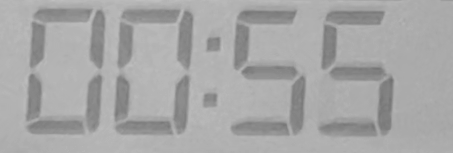

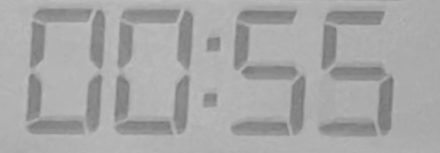

'00155'

cf=[609, 870, 1062, 1028]
best_score=183.25710823280093 ix=2 d=-15 cfp=[609, 870, 1047, 1028]
best_score=183.11341418793012 ix=2 d=-14 cfp=[609, 870, 1048, 1028]
best_score=183.10569852242824 ix=2 d=-12 cfp=[609, 870, 1050, 1028]


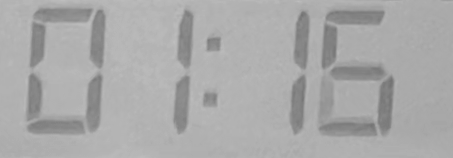

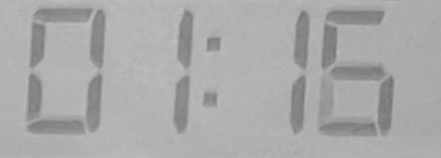

'01115'

cf=[598, 873, 1072, 1042]
best_score=186.82150632033324 ix=2 d=1 cfp=[598, 873, 1073, 1042]
best_score=186.79662100870144 ix=2 d=2 cfp=[598, 873, 1074, 1042]
best_score=186.77901710856736 ix=2 d=3 cfp=[598, 873, 1075, 1042]
best_score=186.76828299576945 ix=2 d=4 cfp=[598, 873, 1076, 1042]
best_score=186.76430830691265 ix=2 d=5 cfp=[598, 873, 1077, 1042]
best_score=186.73556062355235 ix=2 d=6 cfp=[598, 873, 1078, 1042]
best_score=186.73259153474848 ix=2 d=7 cfp=[598, 873, 1079, 1042]
best_score=186.72887705635296 ix=2 d=10 cfp=[598, 873, 1082, 1042]
best_score=186.71686973840588 ix=2 d=11 cfp=[598, 873, 1083, 1042]
best_score=186.7027257494703 ix=2 d=12 cfp=[598, 873, 1084, 1042]
best_score=186.69419568366 ix=2 d=13 cfp=[598, 873, 1085, 1042]
best_score=186.68212485784716 ix=3 d=-15 cfp=[598, 873, 1072, 1027]
best_score=180.8007113082818 ix=3 d=-14 cfp=[598, 873, 1072, 1028]


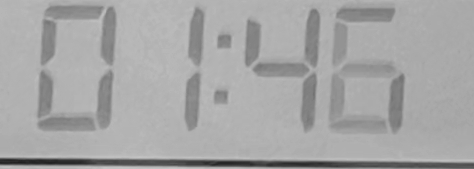

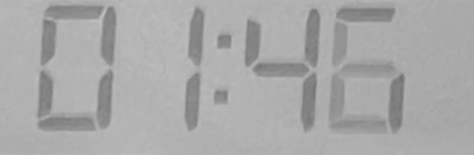

'0114_'

cf=[609, 868, 1062, 1026]
best_score=185.55288377639988 ix=2 d=-15 cfp=[609, 868, 1047, 1026]
best_score=184.9244062733282 ix=2 d=-14 cfp=[609, 868, 1048, 1026]
best_score=184.91515229333083 ix=2 d=-13 cfp=[609, 868, 1049, 1026]


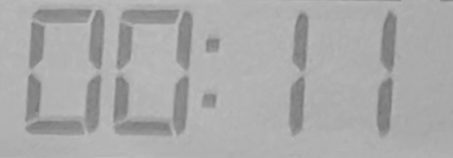

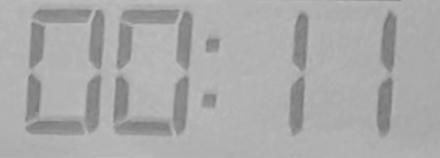

'00111.'

cf=[614, 870, 1059, 1018]
best_score=182.25810512754433 ix=2 d=-10 cfp=[614, 870, 1049, 1018]
best_score=182.2500351006702 ix=2 d=-9 cfp=[614, 870, 1050, 1018]
best_score=182.20049633707947 ix=2 d=-8 cfp=[614, 870, 1051, 1018]
best_score=182.1493342766429 ix=2 d=-7 cfp=[614, 870, 1052, 1018]
best_score=182.12826684732758 ix=2 d=-6 cfp=[614, 870, 1053, 1018]


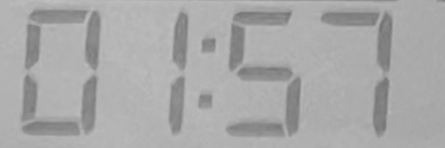

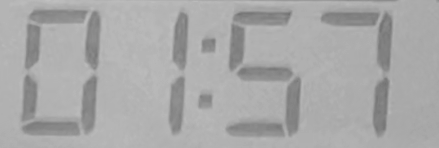

'01157_'

cf=[609, 870, 1062, 1028]
best_score=181.82770979854607 ix=2 d=-15 cfp=[609, 870, 1047, 1028]
best_score=181.6434335388926 ix=2 d=-14 cfp=[609, 870, 1048, 1028]


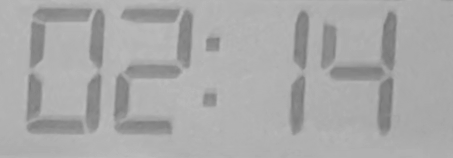

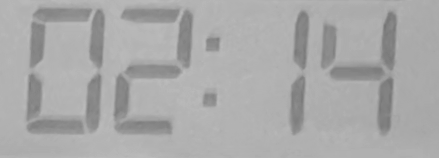

'02114'

cf=[607, 872, 1067, 1025]
best_score=183.65510882301623 ix=2 d=-15 cfp=[607, 872, 1052, 1025]
best_score=183.62335319291867 ix=3 d=4 cfp=[607, 872, 1067, 1029]
best_score=183.619717954011 ix=3 d=5 cfp=[607, 872, 1067, 1030]
best_score=183.61418579314147 ix=3 d=6 cfp=[607, 872, 1067, 1031]
best_score=183.60946604120613 ix=3 d=7 cfp=[607, 872, 1067, 1032]


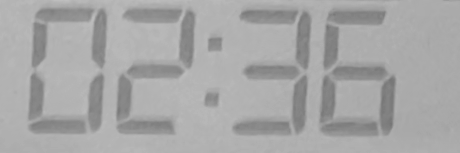

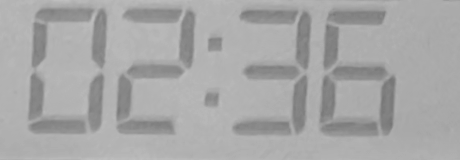

'02136'

cf=[600, 871, 1074, 1040]
best_score=185.30259020971354 ix=2 d=1 cfp=[600, 871, 1075, 1040]
best_score=185.2704773658666 ix=2 d=2 cfp=[600, 871, 1076, 1040]
best_score=185.26052922985644 ix=2 d=3 cfp=[600, 871, 1077, 1040]
best_score=185.24989205921142 ix=2 d=4 cfp=[600, 871, 1078, 1040]
best_score=185.2316319340087 ix=2 d=5 cfp=[600, 871, 1079, 1040]
best_score=185.2216254188435 ix=2 d=6 cfp=[600, 871, 1080, 1040]
best_score=185.20763996266916 ix=2 d=7 cfp=[600, 871, 1081, 1040]
best_score=185.1970766514352 ix=2 d=10 cfp=[600, 871, 1084, 1040]
best_score=185.19327979300465 ix=2 d=11 cfp=[600, 871, 1085, 1040]
best_score=185.18441141327742 ix=2 d=12 cfp=[600, 871, 1086, 1040]
best_score=185.16506336253613 ix=2 d=13 cfp=[600, 871, 1087, 1040]
best_score=185.1536051267552 ix=2 d=14 cfp=[600, 871, 1088, 1040]
best_score=185.1307286449292 ix=3 d=-15 cfp=[600, 871, 1074, 1025]
best_score=179.64618213264225 ix=3 d=-14 cfp=[600, 871, 1074, 1026]
best_score=179.64174079239393 ix=3 d=-13 cfp=[6

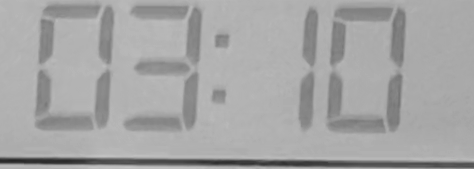

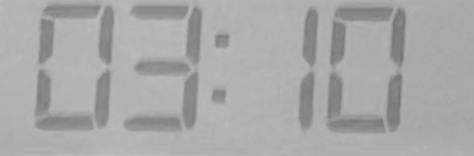

'03110'

cf=[611, 876, 1064, 1029]
best_score=181.38785637120466 ix=2 d=1 cfp=[611, 876, 1065, 1029]
best_score=181.3841684469406 ix=2 d=7 cfp=[611, 876, 1071, 1029]
best_score=181.3697453091226 ix=2 d=8 cfp=[611, 876, 1072, 1029]
best_score=181.35498759894048 ix=2 d=9 cfp=[611, 876, 1073, 1029]
best_score=181.34329886507098 ix=2 d=10 cfp=[611, 876, 1074, 1029]
best_score=181.3389124106637 ix=2 d=12 cfp=[611, 876, 1076, 1029]


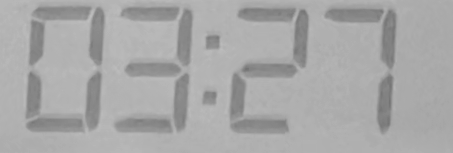

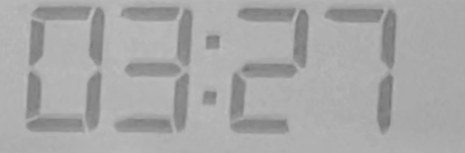

'03127'

cf=[611, 872, 1064, 1030]
best_score=183.4092913087366 ix=2 d=1 cfp=[611, 872, 1065, 1030]
best_score=183.40047241480627 ix=2 d=2 cfp=[611, 872, 1066, 1030]
best_score=183.39130271440789 ix=2 d=3 cfp=[611, 872, 1067, 1030]
best_score=183.37794660545038 ix=2 d=9 cfp=[611, 872, 1073, 1030]
best_score=183.37681242429866 ix=2 d=10 cfp=[611, 872, 1074, 1030]
best_score=183.36329347023494 ix=2 d=11 cfp=[611, 872, 1075, 1030]


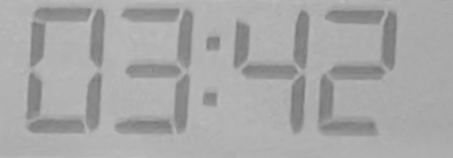

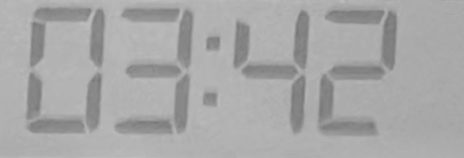

'03142'

cf=[609, 870, 1062, 1028]
best_score=184.31360372873468 ix=2 d=-15 cfp=[609, 870, 1047, 1028]
best_score=184.23479390265567 ix=2 d=-14 cfp=[609, 870, 1048, 1028]
best_score=184.23329074815766 ix=2 d=-13 cfp=[609, 870, 1049, 1028]


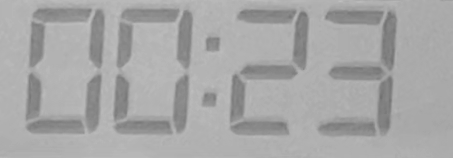

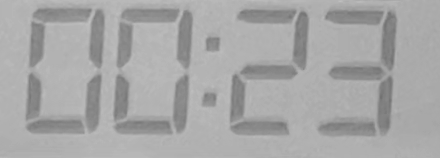

'00123'

cf=[609, 872, 1062, 1030]
best_score=182.2843755525873 ix=2 d=-4 cfp=[609, 872, 1058, 1030]
best_score=182.27982308042166 ix=2 d=-3 cfp=[609, 872, 1059, 1030]
best_score=182.27646049831654 ix=2 d=1 cfp=[609, 872, 1063, 1030]
best_score=182.26856273965987 ix=2 d=2 cfp=[609, 872, 1064, 1030]
best_score=182.246910817916 ix=2 d=3 cfp=[609, 872, 1065, 1030]
best_score=182.2328304455356 ix=2 d=4 cfp=[609, 872, 1066, 1030]
best_score=182.22796214686855 ix=2 d=8 cfp=[609, 872, 1070, 1030]
best_score=182.22296328210035 ix=2 d=9 cfp=[609, 872, 1071, 1030]
best_score=182.21316877852828 ix=2 d=10 cfp=[609, 872, 1072, 1030]
best_score=182.20790908850117 ix=2 d=11 cfp=[609, 872, 1073, 1030]
best_score=182.19558456717687 ix=2 d=12 cfp=[609, 872, 1074, 1030]


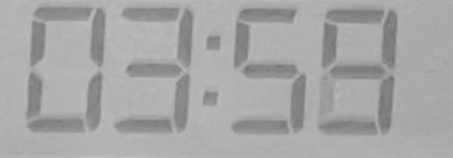

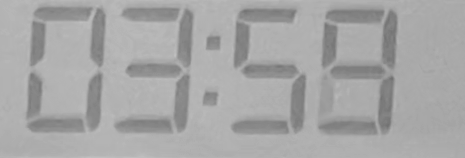

'03159'

cf=[609, 868, 1062, 1021]
best_score=183.92715862140173 ix=2 d=-15 cfp=[609, 868, 1047, 1021]
best_score=183.6051162153288 ix=2 d=-14 cfp=[609, 868, 1048, 1021]
best_score=183.59651059838308 ix=2 d=-13 cfp=[609, 868, 1049, 1021]
best_score=183.59581314203047 ix=2 d=-12 cfp=[609, 868, 1050, 1021]


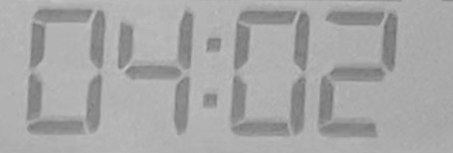

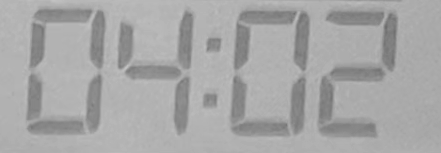

'04102'

cf=[611, 870, 1064, 1023]
best_score=184.2812306275816 ix=2 d=-15 cfp=[611, 870, 1049, 1023]
best_score=183.988651279286 ix=2 d=-14 cfp=[611, 870, 1050, 1023]


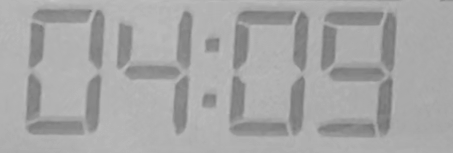

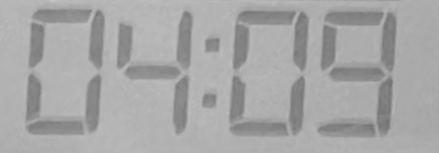

'04109'

cf=[613, 872, 1066, 1030]
best_score=183.3745942987397 ix=2 d=-15 cfp=[613, 872, 1051, 1030]
best_score=183.16010524870677 ix=2 d=-14 cfp=[613, 872, 1052, 1030]
best_score=183.15780260021336 ix=2 d=-13 cfp=[613, 872, 1053, 1030]


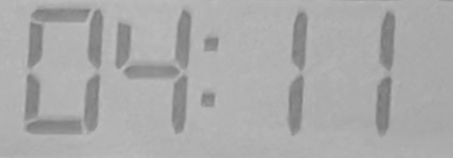

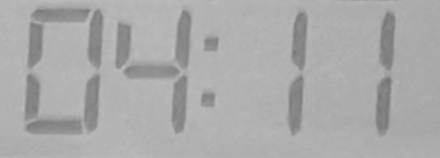

'04111'

cf=[609, 870, 1062, 1028]
best_score=183.54754483554825 ix=2 d=-15 cfp=[609, 870, 1047, 1028]
best_score=183.50748976526037 ix=2 d=-14 cfp=[609, 870, 1048, 1028]
best_score=183.4963722368633 ix=2 d=-13 cfp=[609, 870, 1049, 1028]
best_score=183.49231620106048 ix=2 d=-12 cfp=[609, 870, 1050, 1028]
best_score=183.4912933879731 ix=2 d=14 cfp=[609, 870, 1076, 1028]


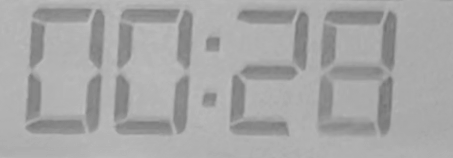

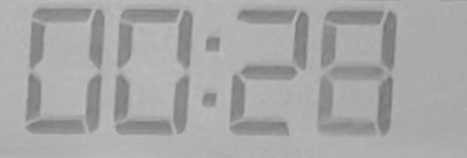

'00128'

cf=[609, 868, 1062, 1021]
best_score=184.891888420436 ix=2 d=-15 cfp=[609, 868, 1047, 1021]
best_score=184.5387991847873 ix=2 d=-14 cfp=[609, 868, 1048, 1021]


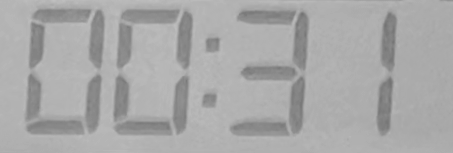

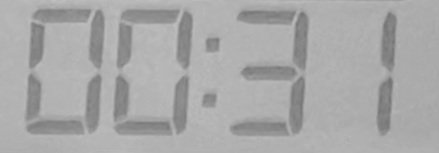

'00131'

cf=[609, 870, 1062, 1028]
best_score=184.21179860444073 ix=2 d=-15 cfp=[609, 870, 1047, 1028]
best_score=184.15957146393527 ix=2 d=-14 cfp=[609, 870, 1048, 1028]
best_score=184.15091647157834 ix=2 d=-12 cfp=[609, 870, 1050, 1028]
best_score=184.12772668608017 ix=2 d=-11 cfp=[609, 870, 1051, 1028]
best_score=184.12055632978027 ix=2 d=-10 cfp=[609, 870, 1052, 1028]


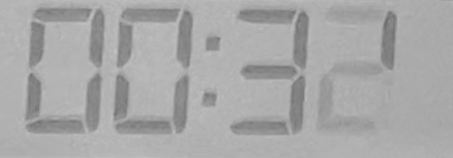

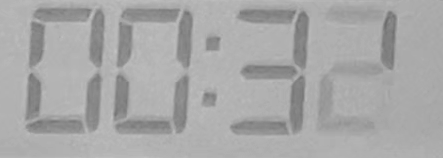

'00131'

<IPython.core.display.Javascript object>

In [62]:
def score_crop(a, cf):
    l, t, r, b = cf
    perimeter = np.concatenate(
        [
            a[t:b, l].flatten(),
            a[t:b, r].flatten(),
            a[t, l:r].flatten(),
            a[t, l:r].flatten(),
        ]
    )
    score = perimeter.mean() + perimeter.std()

    return score


def tidy_crop_frame(a, cf, w=15):
    best_score = score_crop(a, cf)
    best_crop = cf

    print(f"{cf=}")
    for ix in range(len(cf)):
        dr = 1 if (ix >= 2) else -1
        for d in range(-w * dr, w * dr):
            cfp = cf.copy()
            cfp[ix] += d
            score = score_crop(a, cfp)
            if score < best_score:
                print(f"{best_score=} {ix=} {d=} {cfp=}")
                best_score = score
                best_crop = cfp

    return best_crop


def ssocr_subimage(im, bbox, selection, ssocr_config):
    xy = make_polygons_2d(bbox)

    l, t, r, b = (xy[:, 0].min(), xy[:, 1].min(), xy[:, 0].max(), xy[:, 1].max())
    w = abs(l - r)
    h = abs(t - b)

    s = selection
    init_crop_frame = [
        int(round(e))
        for e in (
            l + s[0] * w,
            t + s[1] * h,
            r + s[2] * w,
            b + s[3] * h,
        )
    ]

    imc1 = im.crop(init_crop_frame)
    crop_frame = tidy_crop_frame(np.asarray(im), init_crop_frame)
    imc = im.crop(crop_frame)

    return imc1, imc, run_ssocr(np.asarray(imc), *ssocr_config)


config = {
    "SPEED": dict(
        sel=(-0.2, 1.25, 1.03, 2.7),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "WATTS": dict(
        sel=(-0.2, 1.1, 0.6, 2.5),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "CADENCE": dict(
        sel=(0, 1.25, 0.20, 2.9),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "DISTANCE": dict(
        sel=(0, 1.3, 0.75, 3.25),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "TIME": dict(
        sel=(-1.2, 1.2, 1.45, 2.75),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
    "CALORIES": dict(
        sel=(0, 1.2, 0.2, 2.5),
        ssocr_conf=(
            {"number-digits": -1, "threshold": 40},
            [],
        ),
    ),
}


landmark = "TIME"
for frame in sample:
    cfg = config[landmark]

    im = images[sample.index(frame)]

    bbox = (
        matches.query("frame == @frame")
        .query("landmark == @landmark")
        .landmark_bbox.squeeze()
    )

    _im, im, out = ssocr_subimage(im.convert("L"), bbox, cfg["sel"], cfg["ssocr_conf"])

    _im
    im
    out

In [24]:
matches

,landmark,inference_text,inference_score,landmark_bbox,match_bbox,frame
0,CADENCE,None,NaN,"[[1121.0, 440.0], [1338.0, 445.0], [1337.0, 50...",None,/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
1,CALORIES,None,NaN,"[[1093.0, 796.0], [1319.0, 803.0], [1317.0, 86...",None,/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
2,DISTANCE,0.14,0.972719,"[[216.0, 800.0], [448.0, 800.0], [448.0, 850.0...","[[294.0, 879.0], [592.0, 879.0], [592.0, 995.0...",/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
3,SPEED,15.2,0.999608,"[[214.0, 435.0], [370.0, 435.0], [370.0, 492.0...","[[254.0, 497.0], [523.0, 503.0], [520.0, 658.0...",/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
4,TIME,EE:00,0.903045,"[[758.0, 796.0], [882.0, 796.0], [882.0, 858.0...","[[616.0, 879.0], [1008.0, 879.0], [1008.0, 999...",/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
5,WATTS,89,0.975049,"[[707.0, 434.0], [879.0, 439.0], [877.0, 503.0...","[[790.0, 508.0], [996.0, 508.0], [996.0, 645.0...",/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
0,CADENCE,64,0.999579,"[[1123.0, 442.0], [1338.0, 447.0], [1337.0, 50...","[[1178.0, 522.0], [1366.0, 522.0], [1366.0, 65...",/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
1,CALORIES,None,NaN,"[[1093.0, 800.0], [1321.0, 807.0], [1319.0, 86...",None,/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
2,DISTANCE,0.83,0.997219,"[[218.0, 802.0], [448.0, 802.0], [448.0, 852.0...","[[298.0, 883.0], [574.0, 883.0], [574.0, 999.0...",/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...
3,SPEED,None,NaN,"[[218.0, 437.0], [370.0, 437.0], [370.0, 494.0...",None,/bucket/exercise-machina/tmpqdhq4d5e/frames/ou...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(229,)

<Axes: >

(array([ 60,  68,  77, 137, 154]),
 {'prominences': array([41.79703794, 23.4683931 , 36.00273859, 10.97588511, 14.98559129]),
  'left_bases': array([ 47,  67,  67,  90, 139]),
  'right_bases': array([ 67,  69, 139, 139, 202])})

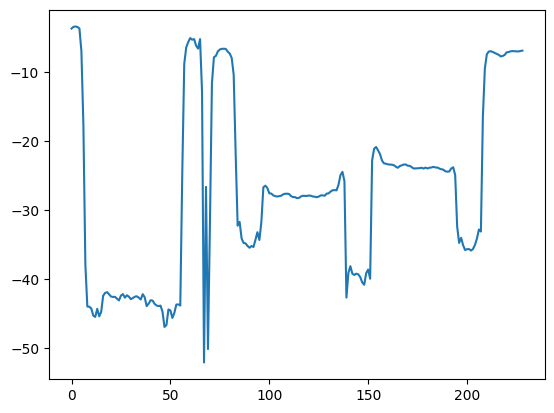

<IPython.core.display.Javascript object>

In [233]:
import scipy.signal as ss

i = 1
a.std(i).shape
pd.Series(-a.std(i)).plot()
# plt.imshow(ima[:, :, 1])
# plt.imshow(ima[:, :, 2])

ss.find_peaks(-a.std(i), prominence=10)

In [115]:
print("Building up some pixels for clustering")

import sklearn.cluster

# Build k-means model to threshold images.
pixels = np.asarray(imc)
pixels.shape
_pixels = pixels.reshape(-1, 3)

print("Building k-means model")
# Train K-means model
kmeans = sklearn.cluster.KMeans(n_clusters=4)
kmeans.fit(_pixels)



Building up some pixels for clustering


(422, 843, 3)

Building k-means model


KMeans(n_clusters=4)

<IPython.core.display.Javascript object>

In [139]:
pixels

array([[[182, 201, 159],
        [182, 201, 159],
        [182, 201, 159],
        ...,
        [ 59,  57,  53],
        [ 59,  57,  53],
        [ 59,  57,  53]],

       [[181, 200, 158],
        [181, 200, 158],
        [181, 200, 158],
        ...,
        [ 58,  56,  52],
        [ 58,  56,  52],
        [ 58,  56,  52]],

       [[181, 200, 158],
        [181, 200, 158],
        [181, 200, 158],
        ...,
        [ 58,  56,  52],
        [ 58,  56,  52],
        [ 58,  56,  52]],

       ...,

       [[ 98, 101,  80],
        [112, 119,  90],
        [119, 126,  97],
        ...,
        [ 48,  43,  40],
        [ 48,  43,  40],
        [ 48,  43,  40]],

       [[ 96,  99,  78],
        [111, 118,  89],
        [119, 126,  97],
        ...,
        [ 48,  43,  40],
        [ 48,  43,  40],
        [ 47,  42,  39]],

       [[ 93,  96,  75],
        [107, 114,  85],
        [119, 126,  97],
        ...,
        [ 50,  45,  42],
        [ 49,  44,  41],
        [ 47,  42,  39]]

<IPython.core.display.Javascript object>

(422, 843)

(422, 843)

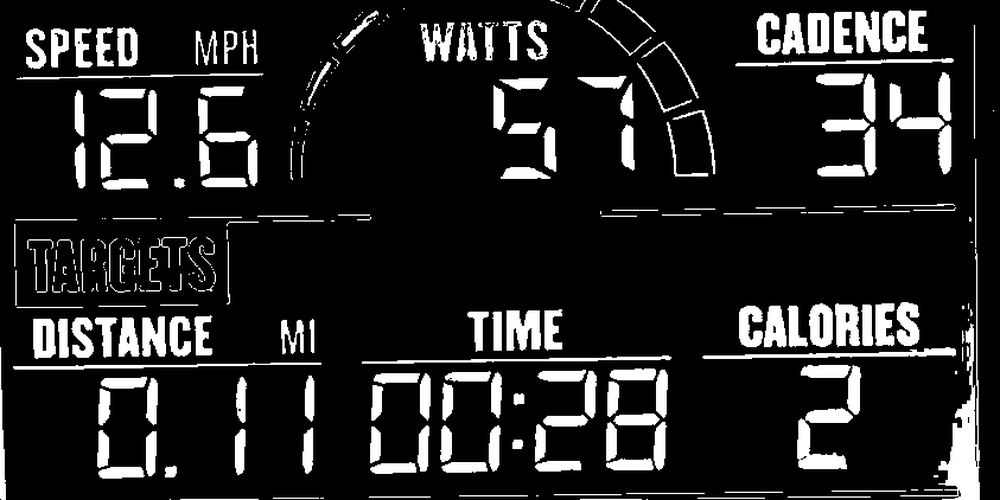

[2023/05/19 15:32:13] ppocr DEBUG: dt_boxes num : 11, elapse : 0.22794365882873535
[2023/05/19 15:32:13] ppocr DEBUG: cls num  : 11, elapse : 0.04181170463562012
[2023/05/19 15:32:14] ppocr DEBUG: rec_res num  : 11, elapse : 0.590831995010376


,bbox,inference,inference_text,inference_score
0,"[[423.0, 21.0], [548.0, 21.0], [548.0, 61.0], ...","(WAYTS, 0.7229107022285461)",WAYTS,0.722911
1,"[[755.0, 12.0], [927.0, 8.0], [928.0, 52.0], [...","(CADENCE, 0.9986267685890198)",CADENCE,0.998627
2,"[[22.0, 27.0], [139.0, 25.0], [140.0, 70.0], [...","(SPEED, 0.9982820749282837)",SPEED,0.998282
3,"[[192.0, 28.0], [260.0, 28.0], [260.0, 68.0], ...","(MPH, 0.9933496117591858)",MPH,0.993350
4,"[[816.0, 76.0], [951.0, 76.0], [951.0, 174.0],...","(34, 0.9999540448188782)",34,0.999954
5,"[[26.0, 234.0], [221.0, 234.0], [221.0, 297.0]...","(TARCETS, 0.9647909998893738)",TARCETS,0.964791
6,"[[467.0, 308.0], [565.0, 308.0], [565.0, 351.0...","(TIME, 0.9941023588180542)",TIME,0.994102
7,"[[738.0, 304.0], [918.0, 302.0], [919.0, 346.0...","(CALORIES, 0.9953020811080933)",CALORIES,0.995302
8,"[[32.0, 318.0], [211.0, 315.0], [212.0, 356.0]...","(DISTANCE, 0.9986192584037781)",DISTANCE,0.998619
9,"[[277.0, 318.0], [315.0, 316.0], [317.0, 356.0...","(MI, 0.8454282283782959)",MI,0.845428


<IPython.core.display.Javascript object>

In [163]:
imb = kmeans.predict(_pixels).reshape(422, 843) == 3
imb.shape
#plt.imshow(imb)
imbb = np.zeros_like(pixels)
# imbb
imbb[:, :, 0] = imb * 255
imbb[:, :, 1] = imb * 255
imbb[:, :, 2] = imb * 255
imbb = Image.fromarray(imbb)

imbb.height, imbb.width

resize_width = 1000
resize_height = int(
    imbb.height * (resize_width / imbb.width)
)
resized_img = imbb.resize(
    (resize_width, resize_height), Image.LANCZOS
)

resized_img


paddle_results_to_df(ocr.ocr(np.asarray(resized_img), cls=True)[0])


In [ ]:
# list(Run("BuildMonitorDatasetFlow/24").steps())

Step("BuildMonitorDatasetFlow/24/text_detect_phase2").phase_2_detection_results

In [ ]:
ocr_df.loc[:, ["speed", "watts", "cadence"]]

ocr_df.speed.unique()

In [ ]:
trdf = pd.read_csv("./top-row-states.csv")

p9.ggplot(trdf, p9.aes("cadence", "speed")) + p9.geom_line() + p9.geom_point()

p9.ggplot(trdf, p9.aes("cadence", "watts")) + p9.geom_line() + p9.geom_point()

In [ ]:
ocr_df.loc[:, ["time", "distance", "calories"]].to_csv("moo.csv")

In [ ]:
lnl = sum(
    np.log(
        1e-3
        + rapidfuzz.process.cdist(
            ocr_df[term],
            trdf[term].astype("str"),
            processor=lambda w: "".join(e for e in w if e.isdigit()),
        )
    )
    for term in ("speed", "watts", "cadence")
)
n = 11
pd.concat(
    [
        ocr_df.reset_index(drop=True),
        trdf.loc[lnl.argmax(axis=1)].reset_index(drop=True),
    ],
    axis="columns",
    ignore_index=True,
).to_csv("ocr.csv", index=False)

In [ ]:
pd.json_normalize(
    Flow("BuildMonitorDatasetFlow").latest_successful_run.data.phase1_results[
        "predictions"
    ]
).loc[:, ["rec_texts", "det_polygons"]].explode(["rec_texts", "det_polygons"]).query(
    "rec_texts in ('speed', 'cadence', 'distance', 'calories')"
)

In [ ]:
from mmocr.apis import MMOCRInferencer

ocr = MMOCRInferencer(det="DBNetpp", rec="ABINet")

ocr("/bucket/exercise-machina/frames",
    batch_size=8,
    out_dir="/bucket/exercise-machina/frames-ocr",
   save_pred=True
   )

#x = ocr("output_001.png", show=False, print_result=False, return_vis=False)


In [ ]:
import cv2
import numpy as np
from fuzzywuzzy import fuzz


def display_image(image, width_inches=12.5):
    height, width, _ = image.shape
    aspect_ratio = height / width

    fig_width = width_inches
    fig_height = width_inches * aspect_ratio

    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.imshow(image)
    plt.axis("off")
    plt.show()


def draw_ocr_results(image, ocr_data, extra_polygons=[]):
    # Convert the image to BGR format for drawing with OpenCV
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for ix, row in ocr_data.iterrows():
        text = row["rec_texts"]
        polygon = row["det_polygons"]
        points = np.array(polygon).reshape(-1, 2).astype(np.int32)

        # Draw the bounding box
        cv2.polylines(image, [points], isClosed=True, color=(0, 255, 255), thickness=2)

        # Calculate the center of the bounding box
        center = points.mean(axis=0).astype(np.int32)

        # Put the text annotation in the center of the bounding box
        cv2.putText(
            image, text, tuple(center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2
        )

    for pg in extra_polygons:
        points = np.array(pg).reshape(-1, 2).astype(np.int32)

        # Draw the bounding box
        cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=3)

    return image


def find_most_similar_text(df, query, similarity_threshold=90):
    best_match = None
    best_similarity = 0

    for index, row in df.iterrows():
        similarity = fuzz.ratio(query, row["rec_texts"])
        if (similarity >= similarity_threshold) and (similarity > best_similarity):
            best_similarity = similarity
            best_match = row

    if best_match is not None:
        return np.asarray(best_match["det_polygons"]).reshape(-1, 2).astype(np.int32)

    return []


def super_bounding_box(landmarks, keys):
    min_x, min_y = float("inf"), float("inf")
    max_x, max_y = float("-inf"), float("-inf")

    for key in keys:
        if key not in landmarks:
            raise ValueError(f"Key '{key}' not found in landmarks.")

        bounding_box = landmarks[key]
        x1, y1 = bounding_box[:, 0].min(), bounding_box[:, 1].min()
        x2, y2 = bounding_box[:, 0].max(), bounding_box[:, 1].max()

        min_x, min_y = min(min_x, x1), min(min_y, y1)
        max_x, max_y = max(max_x, x2), max(max_y, y2)

    return np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]])


def infill_bounding_box(landmarks, key1, key2):
    if key1 not in landmarks:
        raise ValueError(f"Key '{key1}' not found in landmarks.")
    if key2 not in landmarks:
        raise ValueError(f"Key '{key2}' not found in landmarks.")

    bbox1 = landmarks[key1]
    bbox2 = landmarks[key2]

    x1_1, y1_1 = bbox1[:, 0].min(), bbox1[:, 1].min()
    x1_2, y1_2 = bbox1[:, 0].max(), bbox1[:, 1].max()

    x2_1, y2_1 = bbox2[:, 0].min(), bbox2[:, 1].min()
    x2_2, y2_2 = bbox2[:, 0].max(), bbox2[:, 1].max()

    min_x = max(x1_2, x2_1)
    max_x = min(x1_1, x2_2)
    min_y = max(y1_1, y2_1)
    max_y = min(y1_2, y2_2)

    return np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]])


def infill_top_bottom_bbox(landmarks, top_key, bottom_key):
    if top_key not in landmarks:
        raise ValueError(f"Key '{top_key}' not found in landmarks.")
    if bottom_key not in landmarks:
        raise ValueError(f"Key '{bottom_key}' not found in landmarks.")

    top_bbox = landmarks[top_key]
    bottom_bbox = landmarks[bottom_key]

    top_left = [top_bbox[:, 0].min(), top_bbox[:, 1].max()]
    top_right = [top_bbox[:, 0].max(), top_bbox[:, 1].max()]

    bottom_left = [bottom_bbox[:, 0].min(), bottom_bbox[:, 1].min()]
    bottom_right = [bottom_bbox[:, 0].max(), bottom_bbox[:, 1].min()]

    return np.array([top_left, top_right, bottom_right, bottom_left])


# Example usage:
# landmarks = {
#     'top_key': np.array([[10, 20], [30, 20], [30, 40], [10, 40]]),
#     'bottom_key': np.array([[15, 50], [25, 50], [25, 60], [15, 60]]),
# }
# infill_top_bottom = infill_top_bottom_bbox(landmarks, 'top_key', 'bottom_key')
# print(infill_top_bottom)


def build_ss_polygons(df):
    landmarks = [
        "rogue",
        "intervals",
        "speed",
        "mph",
        "watts",
        "cadence",
        "targets",
        "distance",
        "time",
        "calories",
        "heart",
        "rate",
        "intervals",
    ]
    landmark_map = dict((e, find_most_similar_text(df, e)) for e in landmarks)

    landmark_map["smwc"] = super_bounding_box(
        landmark_map, ["speed", "mph", "watts", "cadence"]
    )
    landmark_map["tdtc"] = super_bounding_box(
        landmark_map, ["targets", "distance", "time", "calories"]
    )
    landmark_map["hr"] = super_bounding_box(landmark_map, ["heart", "rate"])

    #     landmark_map["upper_row"] = infill_top_bottom_bbox(
    #         landmark_map, "speed+mph", "tdtc"
    #     )
    #     landmark_map["lower_row"] = infill_top_bottom_bbox(landmark_map, "tdtc", "hr")

    return landmark_map


#     return [
#         landmark_map["upper_row"],
#         landmark_map["lower_row"],
#     ]


ocr_df = pd.DataFrame(x["predictions"][0])

image = cv2.imread("output_001.png")


digit_bboxes = build_ss_polygons(ocr_df)

image_p = draw_ocr_results(image, ocr_df, [])

display_image(image_p)

In [ ]:
display_image(image)

In [ ]:
# digit_bboxes

from scipy.stats import linregress

keys = (
    ["rogue", "intervals"]
    + ["speed", "mph", "watts", "cadence"]
    + ["targets", "distance", "time", "calories"]
    + ["heart", "rate"]
)

for key in keys:
    slope, *rest = linregress(digit_bboxes[key][:, 0], digit_bboxes[key][:, 1])
    angle_rad = np.arctan(slope)
    angle_deg = np.degrees(angle_rad)

    key, slope, angle_deg

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def estimate_angle_from_horizontal(bbox):
    # Get the x and y coordinates of the bounding box corners
    x = bbox[:, 0].reshape(-1, 1)
    y = bbox[:, 1]

    # Fit a linear regression model
    lr = LinearRegression()
    lr.fit(x, y)

    # Calculate the angle from the slope using arctan
    angle_rad = np.arctan(lr.coef_[0])
    angle_deg = np.degrees(angle_rad)

    # Adjust the angle to be within -90 to 90 degrees
    if angle_deg > 45:
        angle_deg -= 90
    elif angle_deg < -45:
        angle_deg += 90

    return angle_deg

# Example usage:
# bbox = np.array([[10, 20], [30, 20], [30, 40], [10, 40]])
# angle = estimate_angle_from_horizontal(bbox)
# print(angle)


import cv2
import numpy as np

def optimal_rectangular_transform(bboxes):
    transforms = []
    
    for bbox in bboxes:
        # Estimate angles for each pair of opposite sides
        angle1 = estimate_angle_from_horizontal(bbox[[0, 1], :])
        angle2 = estimate_angle_from_horizontal(bbox[[2, 3], :])
        angle3 = estimate_angle_from_horizontal(bbox[[0, 3], :])
        angle4 = estimate_angle_from_horizontal(bbox[[1, 2], :])

        # Average the angles
        avg_horizontal_angle = (angle1 + angle2) / 2
        avg_vertical_angle = (angle3 + angle4) / 2

        # Get the center of the bounding box
        center = np.mean(bbox, axis=0)

        # Calculate the affine transformation matrix
        horizontal_rotation_matrix = cv2.getRotationMatrix2D(tuple(center), avg_horizontal_angle, 1)
        vertical_rotation_matrix = cv2.getRotationMatrix2D(tuple(center), avg_vertical_angle, 1)

        # Apply the horizontal rotation
        rotated_bbox = cv2.transform(np.float32([bbox]), horizontal_rotation_matrix)[0]

        # Compute the vertical rotation center
        rotated_center = np.mean(rotated_bbox, axis=0)

        # Calculate the vertical rotation matrix based on the rotated center
        vertical_rotation_matrix = cv2.getRotationMatrix2D(tuple(rotated_center), avg_vertical_angle, 1)

        # Store the transformation matrices
        transforms.append((horizontal_rotation_matrix, vertical_rotation_matrix))

    return transforms

# Example usage:
# bboxes = [np.array([[10, 20], [30, 20], [30, 40], [10, 40]])]
# transforms = optimal_rectangular_transform(bboxes)
# print(transforms)


# Example usage:
bboxes = [digit_bboxes["rogue"], digit_bboxes["cadence"]]
transforms = optimal_rectangular_transform(bboxes)
print(transforms)


In [ ]:
import numpy as np
import cv2

def compute_perspective_transform(bbox, target_bbox):
    src_points = np.float32(bbox)
    dst_points = np.float32(target_bbox)
    transformation_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    return transformation_matrix

bboxes = [...]  # List of k bounding boxes
target_bboxes = [...]  # List of k corresponding target rectangular bounding boxes
weights = [...]  # List of k corresponding weights

# Calculate the perspective transformations for each bounding box
transformations = [compute_perspective_transform(bbox, target_bbox)
                   for bbox, target_bbox in zip(bboxes, target_bboxes)]

# Normalize the weights
normalized_weights = np.array(weights) / np.sum(weights)

# Compute the weighted average of the transformation matrices
weighted_avg_transform = np.zeros((3, 3), dtype=np.float32)
for transform, weight in zip(transformations, normalized_weights):
    weighted_avg_transform += transform * weight


In [ ]:
import cv2
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
from io import BytesIO

def display_image(img):
    _, img_encoded = cv2.imencode('.png', img)
    img_bytes = img_encoded.tobytes()
    img_pil = Image.open(BytesIO(img_bytes))
    display(img_pil)

def warp_perspective(angle, scale, tx, ty):
    clear_output(wait=True)
    
    rows, cols, _ = img.shape
    center = (cols // 2, rows // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    rotation_matrix[:, 2] += [tx, ty]

    img_warped = cv2.warpAffine(img, rotation_matrix, (cols, rows))
    display_image(img_warped)

# Load your input image
#img = cv2.imread('path/to/your/image.jpg')
img = image_p

# Create widgets for the transformation parameters
angle_slider = widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description='Rotation Angle')
scale_slider = widgets.FloatSlider(min=0.1, max=3, step=0.1, value=1, description='Scale')
tx_slider = widgets.IntSlider(min=-100, max=100, step=1, value=0, description='Translation X')
ty_slider = widgets.IntSlider(min=-100, max=100, step=1, value=0, description='Translation Y')

widgets.interact(warp_perspective, angle=angle_slider, scale=scale_slider, tx=tx_slider, ty=ty_slider)


In [ ]:
import cv2
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
from io import BytesIO

def display_image(img):
    _, img_encoded = cv2.imencode('.png', img)
    img_bytes = img_encoded.tobytes()
    img_pil = Image.open(BytesIO(img_bytes))
    display(img_pil)


def warp_perspective(pitch, yaw, roll):
    clear_output(wait=True)
    
    def rotation_matrix(axis, angle):
        return cv2.Rodrigues(np.radians(angle) * axis)[0]

    rows, cols, _ = img.shape
    center = (cols // 2, rows // 2)
    focal_length = cols / (2 * np.tan(np.radians(60) / 2))
    
    # Build the rotation matrix
    r_x = rotation_matrix(np.array([1, 0, 0]), pitch)
    r_y = rotation_matrix(np.array([0, 1, 0]), yaw)
    r_z = rotation_matrix(np.array([0, 0, 1]), roll)
    r = np.matmul(np.matmul(r_z, r_y), r_x)

    # Build the perspective transformation matrix
    m = np.zeros((3, 4), dtype=np.float64)
    m[:, :3] = r
    m[:, 3] = [0, 0, focal_length]
    m_4x4 = np.vstack((m, np.array([0, 0, 0, 1])))
    pre_m = np.array([[1, 0, 0, -center[0]], [0, 1, 0, -center[1]], [0, 0, 1, 0], [0, 0, 0, 1]])
    m = np.matmul(pre_m, m_4x4)[:3]
    
    # Apply the perspective transformation
    img_warped = cv2.warpPerspective(img, m, (cols, rows))
    display_image(img_warped)
# Load your input image
#img = cv2.imread('path/to/your/image.jpg')
img = image_p

# Create widgets for the angles
pitch_slider = widgets.FloatSlider(min=-10, max=10, step=0.5, value=0, description='Pitch')
yaw_slider = widgets.FloatSlider(min=-10, max=10, step=0.5, value=0, description='Yaw')
roll_slider = widgets.FloatSlider(min=-10, max=10, step=0.5, value=0, description='Roll')

widgets.interact(warp_perspective, pitch=pitch_slider, yaw=yaw_slider, roll=roll_slider)


In [ ]:
def square_off(bbox, f=0.5):
    x1 = bbox[[0, 1], 0].mean()
    x2 = bbox[[2, 3], 0].mean()

    y1 = bbox[[0, 2], 1].mean()
    y2 = bbox[[1, 3], 1].mean()

    out = np.array(
        [
            [x1, y1],
            [x1, y2],
            [x2, y1],
            [x2, y2],
        ]
    )

    return (1 - f) * bbox + f * out


# Define a 2D numpy array bounding box
src_bbox = digit_bboxes["watts"].astype(np.float32)
src_bbox

dst_bbox = square_off(src_bbox, 1)
# dst_bbox = src_bbox
dst_bbox

# Define the destination bounding box
# dst_bbox = np.array([[100, 100], [200, 100], [200, 200], [100, 200]], dtype=np.float32)

# Calculate the perspective transformation matrix
M = cv2.getPerspectiveTransform(src_bbox, dst_bbox)
M

# Now you can use M to transform the original image using cv2.warpPerspective
rows, cols, _ = image_p.shape
display_image(image_p)
display_image(cv2.warpPerspective(image_p, M, (cols, rows)))

In [ ]:
df = pd.DataFrame(
    np.concatenate(
        [
            digit_bboxes[e]
            for e in [
                "speed",
                # "mph",
                # "watts",
                "cadence",
                "distance",
                # "time",
                "calories",
                # "targets",
                # "heart",
                # "rate",
            ]
        ]
    ),
    columns=["x", "y"],
)
# df
# ?linregress
slope, *rest = linregress(df.x.to_numpy(), df.y.to_numpy())

p9.ggplot(df, p9.aes("x", "-y")) + p9.geom_point() + p9.geom_smooth(method="lm")


def warp_perspective(img, angle=0, scale=1, tx=0, ty=0):
    # clear_output(wait=True)

    rows, cols, _ = img.shape
    center = (cols // 2, rows // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    rotation_matrix[:, 2] += [tx, ty]

    return cv2.warpAffine(img, rotation_matrix, (cols, rows))


def crop_image(image, bbox):
    """
    Crop an image (in numpy representation) to the given bounding box.

    Args:
    - image (numpy.ndarray): The input image in numpy format (height, width, channels)
    - bbox (list or tuple): The bounding box as (x_min, y_min, x_max, y_max)

    Returns:
    - cropped_image (numpy.ndarray): The cropped image
    """
    x_min, y_min, x_max, y_max = bbox
    cropped_image = image[y_min:y_max, x_min:x_max]

    return cropped_image


width = df.x.max() - df.x.min()
height = df.y.max() - df.y.min()
(width, height)
bbox = np.round(
    np.asarray(
        [
            df.x.min() - 0.05 * width,
            df.y.min() - 0.05 * height,
            df.x.max() + 0.10 * width,
            df.y.max() + 0.45 * height,
        ]
    )
).astype(int)

image_p_c = crop_image(image_p, bbox)


display_image(image_p_c)

angle_rad = np.arctan(slope)
angle_deg = np.degrees(angle_rad)
(slope, angle_rad, angle_deg)

display_image(warp_perspective(image_p_c, angle=angle_deg))

In [ ]:
x.keys()

pd.DataFrame(x["predictions"][0])

plt.imshow(x["visualization"][0])

In [ ]:
1 / 0

In [ ]:
# Iterate through all the image files in the directory
for fname in image_directory.glob("*"):
    if not fname.suffix in {'.png', '.jpg', '.jpeg'}:
        continue
    
    print(f"On image file [{fname}]")

    # Run EasyOCR on the image
    results = reader.readtext(str(fname))

    print(results)



In [ ]:
from mmocr.apis import MMOCRInferencer
infer = MMOCRInferencer(rec='svtr-small')
result = infer(root / "frames/output_001.png", save_vis=True, return_vis=True)
print(result['predictions'])

In [ ]:
plt.imshow(result['visualization'][0])
plt.show()